# COVID19 - Brazil States

# import Ray

In [1]:
from environs import Env
env = Env()
env.str("CUDA_DEVICE_ORDER",'PCI_BUS_ID')
env.int("CUDA_VISIBLE_DEVICES",512)
env.int("NUMBA_ENABLE_CUDASIM",1)
env.bool("OMPI_MCA_opal_cuda_support",True)

import os
import ray
MB=1024*1024
GB=MB*1024
ray.shutdown()
ray.init(object_store_memory=1*GB,memory=1*GB,lru_evict=True,\
         driver_object_store_memory=500*MB,num_gpus=256,num_cpus=2, ignore_reinit_error=True) # , include_webui=False, ignore_reinit_error=True)

# ray.init(lru_evict=True,object_store_memory=2*GB,memory=4*GB,
#          num_gpus=312,num_cpus=10, include_webui=False, ignore_reinit_error=True)

# ray.shutdown()
# ray.init(num_cpus=10,num_gpus=None)

@ray.remote(num_gpus=1)
def use_gpu():
    print("ray.get_gpu_ids(): {}".format(ray.get_gpu_ids()[0]))
    print("CUDA_VISIBLE_DEVICES: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))

use_gpu.remote()

2020-07-06 20:10:18,529	INFO resource_spec.py:212 -- Starting Ray with 0.98 GiB memory available for workers and up to 1.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-06 20:10:18,875	INFO services.py:1170 -- View the Ray dashboard at localhost:8267


ObjectID(45b95b1c8bd3a9c4ffffffff010000c801000000)

# Import Modules

In [2]:
import urllib.request
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

# Download data

In [3]:
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...
(pid=98997) ray.get_gpu_ids(): 255
(pid=98997) CUDA_VISIBLE_DEVICES: 255


In [4]:
df = pd.read_csv("data/dados_total_estados.csv")
df.drop('index', axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') 
df = df[df.date<=datetime.strptime("2020-07-02", '%Y-%m-%d')]
display(df)

date state   city place_type  confirmed  deaths  order_for_place  \
4    2020-07-02    AC  TOTAL      state      14048     378              108   
5    2020-07-01    AC  TOTAL      state      13715     370              107   
6    2020-06-30    AC  TOTAL      state      13253     365              106   
7    2020-06-29    AC  TOTAL      state      13146     361              105   
8    2020-06-28    AC  TOTAL      state      13058     353              104   
...         ...   ...    ...        ...        ...     ...              ...   
3057 2020-02-29    SP  TOTAL      state          2       0                5   
3058 2020-02-28    SP  TOTAL      state          2       0                4   
3059 2020-02-27    SP  TOTAL      state          1       0                3   
3060 2020-02-26    SP  TOTAL      state          1       0                2   
3061 2020-02-25    SP  TOTAL      state          1       0                1   

      is_last      popEst  city_ibge_code  confirmed_per_100k_inhabitants  \
4       False    881935.0            12.0                      1592.86115   
5       False    881935.0            12.0                      1555.10327   
6       False    881935.0            12.0                      1502.71845   
7       False    881935.0            12.0                      1490.58604   
8       False    881935.0            12.0                      1480.60798   
...       ...         ...             ...                             ...   
3057    False  45919049.0            35.0                         0.00436   
3058    False  45919049.0            35.0                         0.00436   
3059    False  45919049.0            35.0                         0.00218   
3060    False  45919049.0            35.0                         0.00218   
3061    False  45919049.0            35.0                         0.00218   

      death_rate  
4         0.0269  
5         0.0270  
6         0.0275  
7         0.0275  
8         0.0270  
...          ...  
3057      0.0000  
3058      0.0000  
3059      0.0000  
3060      0.0000  
3061      0.0000  

[2958 rows x 12 columns]

# Model

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma_2+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + d \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t) + c \cdot a(t)
\end{array}$$

$$\gamma = a + b$$

$$\gamma_2 = c + d$$

$$p=0.2$$

The last equation does not need to be solve because:

$$s + e + i + a + r + k = N$$ 

$N$ is the total population of the region, state or country. If you derivate and by considering population constant during the period of simulation, you get the equation of $k$ without depending of the $N$.

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.

## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: from infected Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$\gamma_2$: from assymptomatic Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed from infected  [1/min]

$b$: recovery rate from infected [1/min]

$c$: mortality of healed from assymptomatic [1/min]

$d$: recovery rate from assymptomatic [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

# Initial parameters

In [5]:
paramOpt=4
changeCSV=False
adjustParam=True
paramSave=False
selectStates=False

## Select Parameters File, Version and Model

In [6]:
if paramOpt==0:
    paramFile="data/param.csv"
    version = "1"
    model = "ManualIC"

if paramOpt==1:
    paramFile="data/param_optimized_DE_Scipy.csv"    
    version = "1002"
    model = "DE_ScipyIC"
    
if paramOpt==2:
    paramFile="data/param_optimized_DE_SciPy_HistMin.csv"
    version = "1002"
    model = "DE_ScipyIC"

if paramOpt==3:
    paramFile="data/param_optimized_Yabox.csv"    
    version = "103"
    model = "YaboxIC"
    
if paramOpt==4:
    paramFile="data/param_optimized_Yabox_HistMin.csv"
    version = "103"
    model = "YaboxIC"

if paramOpt==5:
    paramFile="data/param_optimized_Brute_Force.csv"
    version = "12"
    model = "BruteForceIC"

if paramOpt==6:
    paramFile="data/param_optimized_Brute_Force_HistMin.csv"
    version = "12"
    model = "BruteForceIC"

## Final Adjust in Parameters

In [7]:
dfparam = pd.read_csv(paramFile)
dfparam = dfparam.dropna()

if selectStates:
    states=['SP','MG','AM','PE','ES','RJ']
else:
    states=dfparam.state

if changeCSV:
    dfparam.loc[dfparam.state=='PI','d0'] = 0
    dfparam.loc[dfparam.state=='RR','d0'] = 0
    dfparam.loc[dfparam.state=='AP','d0'] = 0
    dfparam.loc[dfparam.state=='SP','WCASES'] = 0.65

if paramSave:
    dfparam.to_csv(paramFile)    
    
if adjustParam:
    sCorrect=[1.25,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.0,1.0,1.1]
    dfparam.s0=dfparam.s0.multiply(sCorrect[:len(states)], axis=0)

dfparam

state  start-date  prediction-range            s0  e0  a0   i0   r0   d0  \
0     SP  2020-03-15               200  1.141715e+07   0   0  713  300  250   
1     ES  2020-04-01               200  7.193949e+05   0   0   55  250   50   
2     MG  2020-04-01               200  1.590210e+06   0   0  223  250   40   
3     RJ  2020-03-20               200  1.036969e+06   0   0  830  250   50   
4     CE  2020-03-20               200  8.770345e+05   0   0  739  250   50   
5     PE  2020-03-20               200  1.072648e+06   0   0  667  250  100   
6     AM  2020-03-20               200  1.031154e+06   0   0  737  250  100   
7     PA  2020-03-20               200  1.014930e+06   0   0  902  250  100   
8     PI  2020-03-20               200  8.251397e+05   0   0  940  250  100   
9     RR  2020-03-20               200  8.086198e+05   0   0  769  250  100   
10    AP  2020-03-20               200  8.540593e+05   0   0  858  250  100   

    START  RATIO    WCASES      WREC  
0     100   0.15  0.438537  0.004821  
1     100   0.15  0.446217  0.019239  
2     100   0.15  0.301378  0.009798  
3     100   0.15  0.666680  0.031825  
4     100   0.15  0.552314  0.022969  
5     100   0.15  0.435306  0.018729  
6     100   0.15  0.582615  0.003338  
7     100   0.15  0.530999  0.034237  
8     100   0.15  0.318747  0.028869  
9     100   0.15  0.392673  0.039875  
10    100   0.15  0.602988  0.019115

# Define States Array and Import Solver

In [8]:
# Load solver
%reload_ext autoreload
%autoreload 2
import LearnerYabox_v2b as Learner #Yabox

2020-07-06 20:10:30,928	INFO resource_spec.py:212 -- Starting Ray with 0.98 GiB memory available for workers and up to 1.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-06 20:10:31,226	INFO services.py:1170 -- View the Ray dashboard at localhost:8267


## Activate Scrolling

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return true;}

<IPython.core.display.Javascript object>

## Select the Running Type

In [10]:
allStates=False
cleanRecovered=False
version="8"

## Main Loop

In [11]:
results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
        result = f.train.remote() 
        results.append(result)
else:
    state= "RJ"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    parameters
    cleanRecovered = False
    f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
    result = f.train.remote() 
    results.append(result)

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

  0%|          | 78/6125000 [00:26<410:56:01,  4.14it/s]


  0%|          | 325/6125000 [00:49<136:31:31, 12.46it/s]


  0%|          | 406/6125000 [00:54<119:14:02, 14.27it/s]
(pid=99087) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99087)   warnings.warn(warning_msg, ODEintWarning)
  0%|          | 465/6125000 [00:57<108:55:06, 15.62it/s]
(pid=99094) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99094)   warnings.warn(warning_msg, ODEintWarning)
  0%|          | 741/6125000 [01:10<77:03:47, 22.08it/s]


  0%|          | 1378/6125000 [01:31<48:31:19, 35.06it/s]


  0%|          | 2080/6125000 [01:50<38:28:39, 44.20it/s]


  0%|          | 2926/6125000 [02:07<29:19:59, 57.97it/s]


  0%|          | 4186/6125000 [02:25<23:29:52, 72.36it/s]


  0%|          | 6105/6125000 [02:41<20:47:47, 81.73it/s]


  0%|          | 7381/6125000 [02:58<17:30:39, 97.04it/s]


  0%|          | 9316/6125000 [03:13<15:30:58, 109.48it/s]


  0%|          | 10878/6125000 [03:29<14:30:20, 117.08it/s]


  0%|          | 12880/6125000 [03:40<12:54:07, 131.59it/s]
(pid=99090) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99090)   warnings.warn(warning_msg, ODEintWarning)
  0%|          | 12090/6125000 [03:44<13:39:35, 124.31it/s]


  0%|          | 15576/6125000 [04:00<12:12:21, 139.04it/s]


  0%|          | 17578/6125000 [04:16<11:22:49, 149.07it/s]


  0%|          | 17766/6125000 [04:32<10:59:17, 154.39it/s]


  0%|          | 20503/6125000 [04:48<10:31:38, 161.08it/s]


  0%|          | 23220/6125000 [05:04<10:06:33, 167.66it/s]


  0%|          | 27966/6125000 [05:21<8:48:24, 192.31it/s]


  0%|          | 26335/6125000 [05:22<9:18:57, 181.85it/s]
(pid=99096) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99096)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 31626/6125000 [05:32<8:07:47, 208.19it/s]
(pid=99091) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99091)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 31125/6125000 [05:36<8:17:32, 204.13it/s]


  1%|          | 32640/6125000 [05:53<8:19:04, 203.45it/s]


  1%|          | 35245/6125000 [05:57<8:34:44, 197.18it/s]
(pid=99225) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99225)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 37950/6125000 [06:09<7:08:50, 236.57it/s]


  1%|          | 39060/6125000 [06:24<7:36:44, 222.08it/s]


  0%|          | 27028/6125000 [06:33<10:44:01, 157.81it/s]
(pid=99092) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99092)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 41328/6125000 [06:38<7:32:22, 224.14it/s]
(pid=99095) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99095)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 45451/6125000 [06:39<6:42:10, 251.94it/s]


  1%|          | 30876/6125000 [06:56<10:14:55, 165.17it/s]


  1%|          | 53301/6125000 [07:13<6:38:08, 254.17it/s]


  1%|          | 52650/6125000 [07:24<6:36:10, 255.46it/s]
(pid=99088) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99088)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 56616/6125000 [07:29<5:51:14, 287.95it/s]


  1%|          | 61075/6125000 [07:44<5:54:58, 284.71it/s]


  1%|          | 67528/6125000 [08:01<5:19:07, 316.35it/s]


  1%|          | 69378/6125000 [08:02<5:29:58, 305.87it/s]
(pid=99089) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=99089)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 72390/6125000 [08:17<5:08:06, 327.40it/s]


  1%|          | 65341/6125000 [08:33<6:05:42, 276.16it/s]


  1%|▏         | 80200/6125000 [08:47<5:01:18, 334.36it/s]


  1%|▏         | 85491/6125000 [09:03<4:52:19, 344.33it/s]


  1%|▏         | 90525/6125000 [09:19<5:05:45, 328.93it/s]


  2%|▏         | 100576/6125000 [09:36<4:25:11, 378.62it/s]


  1%|          | 66795/6125000 [09:51<6:44:34, 249.57it/s]


  2%|▏         | 102831/6125000 [10:06<4:32:50, 367.87it/s]


  2%|▏         | 122265/6125000 [10:21<3:39:38, 455.50it/s]


  1%|▏         | 79003/6125000 [10:36<5:55:27, 283.48it/s]


  2%|▏         | 125250/6125000 [10:50<4:07:33, 403.94it/s]


  2%|▏         | 114481/6125000 [11:06<4:27:38, 374.28it/s]


  2%|▏         | 137026/6125000 [11:21<3:50:05, 433.75it/s]


  2%|▏         | 144453/6125000 [11:35<3:40:35, 451.85it/s]


  2%|▏         | 150426/6125000 [11:50<3:39:36, 453.42it/s]


  3%|▎         | 173755/6125000 [12:05<3:02:36, 543.15it/s]


  3%|▎         | 165025/6125000 [12:21<3:27:20, 479.09it/s]


  3%|▎         | 186355/6125000 [12:38<2:59:38, 550.97it/s]


  3%|▎         | 195000/6125000 [12:53<3:00:45, 546.79it/s]


  3%|▎         | 179700/6125000 [13:08<3:17:17, 502.26it/s]


  3%|▎         | 208981/6125000 [13:22<2:47:43, 587.86it/s]


  3%|▎         | 198135/6125000 [13:37<3:00:16, 547.95it/s]


  3%|▎         | 185136/6125000 [13:52<3:24:56, 483.04it/s]


  2%|▏         | 149331/6125000 [14:07<4:13:03, 393.57it/s]


  4%|▍         | 248160/6125000 [14:22<2:30:07, 652.42it/s]


  3%|▎         | 161028/6125000 [14:36<4:08:42, 399.67it/s]


  4%|▍         | 268278/6125000 [14:51<2:22:04, 687.05it/s]


  4%|▍         | 263901/6125000 [15:05<2:42:32, 600.96it/s]


  4%|▍         | 259560/6125000 [15:19<2:44:21, 594.78it/s]


  3%|▎         | 186355/6125000 [15:36<3:43:56, 441.98it/s]


  3%|▎         | 193753/6125000 [15:52<3:41:53, 445.49it/s]


  5%|▍         | 280126/6125000 [16:08<2:34:01, 632.46it/s]


  5%|▍         | 296065/6125000 [16:22<2:32:45, 635.99it/s]


  5%|▍         | 303810/6125000 [16:39<2:23:02, 678.28it/s]


  5%|▌         | 315615/6125000 [16:53<2:22:38, 678.77it/s]


  5%|▌         | 323610/6125000 [17:07<2:19:41, 692.15it/s]


  5%|▌         | 333336/6125000 [17:22<2:15:19, 713.30it/s]


  4%|▍         | 239086/6125000 [17:35<3:17:17, 497.23it/s]


  6%|▌         | 355746/6125000 [17:50<2:12:50, 723.81it/s]


  5%|▌         | 320400/6125000 [18:04<2:30:24, 643.19it/s]


  7%|▋         | 433846/6125000 [18:18<1:42:13, 927.92it/s]


  6%|▌         | 339076/6125000 [18:33<2:24:47, 665.97it/s]


  8%|▊         | 472878/6125000 [18:48<1:38:21, 957.76it/s]


  8%|▊         | 484620/6125000 [19:04<1:41:05, 929.86it/s]


  7%|▋         | 419986/6125000 [19:20<2:04:07, 766.07it/s]


  8%|▊         | 514605/6125000 [19:34<1:30:45, 1030.27it/s]


  9%|▊         | 520710/6125000 [19:48<1:33:34, 998.12it/s] 


  9%|▊         | 528906/6125000 [20:02<1:33:28, 997.87it/s]


  8%|▊         | 464166/6125000 [20:17<1:55:29, 816.91it/s]


  9%|▉         | 574056/6125000 [20:31<1:27:13, 1060.67it/s]


  9%|▉         | 577275/6125000 [20:45<1:31:45, 1007.62it/s]


  9%|▊         | 523776/6125000 [20:59<1:33:36, 997.33it/s]


  8%|▊         | 512578/6125000 [21:14<1:48:41, 860.67it/s]


  9%|▉         | 544446/6125000 [21:28<1:42:39, 905.96it/s]


  9%|▉         | 558096/6125000 [21:43<1:39:29, 932.52it/s]


  9%|▉         | 545490/6125000 [21:58<1:46:03, 876.79it/s]


  8%|▊         | 494515/6125000 [22:16<2:02:13, 767.73it/s]


  9%|▉         | 575128/6125000 [22:31<1:45:11, 879.30it/s]


 11%|█▏        | 696790/6125000 [22:46<1:16:40, 1179.90it/s]


 12%|█▏        | 713415/6125000 [23:00<1:17:15, 1167.31it/s]


  7%|▋         | 427350/6125000 [23:14<2:23:44, 660.64it/s]


 12%|█▏        | 736291/6125000 [23:29<1:26:04, 1043.39it/s]


  9%|▉         | 560211/6125000 [23:42<1:51:27, 832.07it/s]


 13%|█▎        | 780625/6125000 [23:56<1:14:32, 1194.92it/s]


 12%|█▏        | 732655/6125000 [24:10<1:11:13, 1261.93it/s]


 11%|█         | 682696/6125000 [24:24<1:31:02, 996.33it/s]


 14%|█▍        | 854778/6125000 [24:38<1:08:33, 1281.11it/s]


 11%|█▏        | 699153/6125000 [24:53<1:30:47, 996.10it/s]


 14%|█▍        | 883785/6125000 [25:08<2:13:32, 654.14it/s]


 12%|█▏        | 742371/6125000 [25:23<1:27:18, 1027.42it/s]


 12%|█▏        | 757065/6125000 [25:39<2:13:15, 671.34it/s]


 13%|█▎        | 768180/6125000 [25:54<1:22:31, 1081.95it/s]


 13%|█▎        | 770661/6125000 [26:08<1:23:09, 1073.19it/s]


  9%|▉         | 555985/6125000 [26:22<2:20:01, 662.84it/s]


  9%|▉         | 566580/6125000 [26:36<2:02:02, 759.09it/s]


 17%|█▋        | 1020306/6125000 [26:50<1:01:20, 1386.95it/s]


 14%|█▎        | 832695/6125000 [27:03<1:16:55, 1146.75it/s]


 16%|█▌        | 976503/6125000 [27:17<58:43, 1461.27it/s]


 16%|█▋        | 996166/6125000 [27:30<58:19, 1465.71it/s]


 17%|█▋        | 1016025/6125000 [27:44<58:24, 1457.83it/s]


 16%|█▌        | 970921/6125000 [27:58<1:06:51, 1284.78it/s]


 17%|█▋        | 1059240/6125000 [28:13<57:03, 1479.80it/s]


 15%|█▌        | 935028/6125000 [28:28<1:08:08, 1269.52it/s]


 16%|█▌        | 952890/6125000 [28:41<1:05:49, 1309.47it/s]


 18%|█▊        | 1090026/6125000 [28:57<1:10:52, 1183.93it/s]


 16%|█▋        | 1007490/6125000 [29:11<58:12, 1465.18it/s]


 18%|█▊        | 1076778/6125000 [29:24<1:00:04, 1400.45it/s]


 17%|█▋        | 1018878/6125000 [29:38<1:00:51, 1398.20it/s]


 12%|█▏        | 720600/6125000 [29:51<1:42:12, 881.23it/s]


 21%|██        | 1290421/6125000 [30:04<51:16, 1571.38it/s]


 18%|█▊        | 1112286/6125000 [30:17<55:28, 1506.20it/s]


 18%|█▊        | 1128753/6125000 [30:30<53:29, 1556.47it/s]


 20%|█▉        | 1220703/6125000 [30:44<1:05:36, 1245.74it/s]


 17%|█▋        | 1016025/6125000 [30:57<1:03:00, 1351.23it/s]


 13%|█▎        | 793170/6125000 [31:11<1:37:58, 907.04it/s]


 20%|█▉        | 1216020/6125000 [31:26<54:53, 1490.55it/s]


 20%|██        | 1237951/6125000 [31:40<52:27, 1552.58it/s]


 14%|█▎        | 833986/6125000 [31:54<1:32:38, 951.85it/s]


 21%|██        | 1274406/6125000 [32:08<47:40, 1695.62it/s]


 21%|██▏       | 1301691/6125000 [32:24<47:54, 1678.12it/s]


 25%|██▍       | 1511191/6125000 [32:38<44:25, 1730.97it/s]


 25%|██▌       | 1535628/6125000 [32:51<44:11, 1730.56it/s]


 24%|██▍       | 1499046/6125000 [33:07<47:44, 1615.05it/s]


 23%|██▎       | 1408681/6125000 [33:21<57:36, 1364.48it/s]


 22%|██▏       | 1375311/6125000 [33:34<44:57, 1760.61it/s]


 15%|█▌        | 936396/6125000 [33:48<1:26:58, 994.24it/s] 


 23%|██▎       | 1420455/6125000 [34:00<45:12, 1734.40it/s]


 24%|██▎       | 1440753/6125000 [34:14<42:48, 1823.60it/s]


 24%|██▍       | 1471470/6125000 [34:29<41:45, 1857.19it/s]


 26%|██▌       | 1567335/6125000 [34:43<1:11:19, 1064.94it/s]


 28%|██▊       | 1734453/6125000 [34:56<41:04, 1781.79it/s]


 17%|█▋        | 1017451/6125000 [35:10<1:18:34, 1083.30it/s]


 26%|██▌       | 1602945/6125000 [35:24<38:50, 1940.53it/s]


 26%|██▌       | 1585090/6125000 [35:39<39:19, 1924.31it/s]


 26%|██▋       | 1610115/6125000 [35:51<38:15, 1966.54it/s]


 28%|██▊       | 1727011/6125000 [36:04<36:26, 2011.67it/s]


 24%|██▎       | 1445850/6125000 [36:17<47:27, 1643.17it/s]


 29%|██▉       | 1779441/6125000 [36:30<35:41, 2029.49it/s]


 28%|██▊       | 1688203/6125000 [36:43<48:01, 1539.53it/s]


 29%|██▉       | 1786995/6125000 [36:55<35:09, 2056.69it/s]


 30%|███       | 1859556/6125000 [37:08<33:02, 2151.44it/s]


 25%|██▌       | 1553203/6125000 [37:21<44:48, 1700.67it/s]


 30%|██▉       | 1821186/6125000 [37:36<35:29, 2021.23it/s]


 30%|██▉       | 1832655/6125000 [37:50<36:57, 1935.67it/s]


 31%|███       | 1910035/6125000 [38:03<38:51, 1808.09it/s]


 27%|██▋       | 1651653/6125000 [38:17<41:02, 1816.79it/s]


 31%|███▏      | 1921780/6125000 [38:30<33:55, 2065.10it/s]


 35%|███▌      | 2147628/6125000 [38:46<33:09, 1998.84it/s]


 33%|███▎      | 2033136/6125000 [38:59<30:34, 2230.53it/s]


 34%|███▍      | 2108431/6125000 [39:12<29:28, 2270.76it/s]


 34%|███▍      | 2089990/6125000 [39:24<29:27, 2282.44it/s]


 37%|███▋      | 2250381/6125000 [39:37<30:56, 2086.56it/s]


 38%|███▊      | 2316628/6125000 [39:50<29:10, 2176.18it/s]


 36%|███▋      | 2227105/6125000 [40:02<27:14, 2385.32it/s]


 35%|███▍      | 2122830/6125000 [40:15<30:30, 2186.64it/s]


 35%|███▍      | 2141415/6125000 [40:28<30:01, 2210.71it/s]


 39%|███▉      | 2410110/6125000 [40:43<43:13, 1432.63it/s]


 39%|███▊      | 2372931/6125000 [40:57<28:19, 2207.60it/s]


 34%|███▍      | 2085903/6125000 [41:09<39:51, 1688.67it/s]


 38%|███▊      | 2338203/6125000 [41:22<27:05, 2329.21it/s]


 41%|████▏     | 2530125/6125000 [41:35<25:51, 2317.29it/s]


 40%|████      | 2460871/6125000 [41:48<24:01, 2542.40it/s]


 36%|███▌      | 2180916/6125000 [42:04<37:08, 1770.22it/s]


 43%|████▎     | 2625486/6125000 [42:16<24:56, 2338.77it/s]


 34%|███▍      | 2087946/6125000 [42:29<32:54, 2044.75it/s]


 26%|██▌       | 1562028/6125000 [42:41<48:21, 1572.80it/s]


 26%|██▌       | 1581531/6125000 [42:53<48:01, 1576.93it/s]


 26%|██▌       | 1585090/6125000 [43:06<2:25:44, 519.18it/s]


 43%|████▎     | 2623195/6125000 [43:18<22:57, 2542.98it/s]


 27%|██▋       | 1624503/6125000 [43:31<46:52, 1600.16it/s]


 27%|██▋       | 1648020/6125000 [43:46<48:11, 1548.25it/s]


 37%|███▋      | 2275911/6125000 [44:00<31:37, 2028.86it/s]


 46%|████▌     | 2802528/6125000 [44:14<22:36, 2448.80it/s]


 47%|████▋     | 2905255/6125000 [44:27<22:05, 2429.29it/s]


 46%|████▌     | 2802528/6125000 [44:39<21:00, 2634.83it/s]


 47%|████▋     | 2895621/6125000 [44:52<22:09, 2429.81it/s]


 45%|████▌     | 2764776/6125000 [45:05<22:33, 2481.99it/s]


 45%|████▌     | 2774190/6125000 [45:21<1:49:41, 509.15it/s]


 46%|████▌     | 2804896/6125000 [45:33<23:04, 2397.21it/s]


 46%|████▋     | 2835771/6125000 [45:45<21:45, 2520.20it/s]


 47%|████▋     | 2898028/6125000 [45:58<20:09, 2667.39it/s]


 49%|████▊     | 2982903/6125000 [46:10<18:20, 2854.95it/s]


 50%|█████     | 3083886/6125000 [46:23<18:11, 2785.41it/s]


 50%|████▉     | 3056628/6125000 [46:36<17:49, 2869.27it/s]


 43%|████▎     | 2659971/6125000 [46:51<54:11, 1065.81it/s] 


 43%|████▎     | 2648451/6125000 [47:04<26:00, 2227.47it/s]


 54%|█████▍    | 3301165/6125000 [47:18<18:05, 2600.50it/s]


 53%|█████▎    | 3244878/6125000 [47:31<17:50, 2691.42it/s]


 54%|█████▍    | 3296028/6125000 [47:44<17:54, 2632.34it/s]


 53%|█████▎    | 3219453/6125000 [47:56<17:31, 2764.13it/s]


 55%|█████▍    | 3355345/6125000 [48:08<15:18, 3016.69it/s]


 53%|█████▎    | 3234696/6125000 [48:21<18:34, 2594.26it/s]


 53%|█████▎    | 3247426/6125000 [48:36<1:17:04, 622.24it/s]


 56%|█████▌    | 3415191/6125000 [48:48<13:47, 3274.62it/s]


 47%|████▋     | 2888406/6125000 [48:59<22:35, 2386.92it/s]


 48%|████▊     | 2939100/6125000 [49:11<25:30, 2081.25it/s]


 63%|██████▎   | 3862810/6125000 [49:23<07:52, 4790.39it/s]


 58%|█████▊    | 3539130/6125000 [49:34<16:51, 2557.31it/s]


 56%|█████▌    | 3433510/6125000 [49:48<16:52, 2659.30it/s]


 59%|█████▉    | 3608641/6125000 [50:02<16:30, 2540.67it/s]


 57%|█████▋    | 3501981/6125000 [50:14<16:11, 2701.17it/s]


 67%|██████▋   | 4114146/6125000 [50:28<06:41, 5002.73it/s]


 62%|██████▏   | 3815703/6125000 [50:40<10:55, 3520.81it/s]


 38%|███▊      | 2320935/6125000 [50:52<32:27, 1953.17it/s]


 63%|██████▎   | 3876720/6125000 [51:03<13:10, 2844.74it/s]


 63%|██████▎   | 3860031/6125000 [51:15<11:07, 3391.19it/s]


 39%|███▉      | 2388205/6125000 [51:26<31:10, 1997.52it/s]


 54%|█████▎    | 3278080/6125000 [51:38<18:48, 2522.14it/s]


 66%|██████▌   | 4014361/6125000 [51:52<12:35, 2795.54it/s]


 68%|██████▊   | 4145760/6125000 [52:04<07:40, 4298.89it/s]


 68%|██████▊   | 4194856/6125000 [52:16<07:22, 4357.34it/s]


 41%|████      | 2509920/6125000 [52:27<29:51, 2017.59it/s]


 65%|██████▍   | 3980431/6125000 [52:39<13:21, 2675.76it/s]


 69%|██████▊   | 4200651/6125000 [52:53<09:12, 3481.79it/s]


 66%|██████▌   | 4051281/6125000 [53:05<10:57, 3151.87it/s]


 67%|██████▋   | 4134250/6125000 [53:18<11:28, 2893.19it/s]


 43%|████▎     | 2614041/6125000 [53:31<27:51, 2101.09it/s]


 74%|███████▍  | 4525536/6125000 [53:44<05:31, 4827.59it/s]


 44%|████▎     | 2666895/6125000 [53:56<27:01, 2132.03it/s]


 57%|█████▋    | 3507276/6125000 [54:07<19:47, 2205.16it/s]


 44%|████▍     | 2713285/6125000 [54:18<26:30, 2145.42it/s]


 73%|███████▎  | 4489506/6125000 [54:29<07:22, 3692.10it/s]


 71%|███████   | 4355676/6125000 [54:40<08:54, 3308.82it/s]


 75%|███████▍  | 4570776/6125000 [54:51<07:01, 3686.29it/s]


 80%|████████  | 4925091/6125000 [55:03<03:57, 5050.05it/s]


 46%|████▋     | 2840536/6125000 [55:17<25:35, 2139.68it/s]


 47%|████▋     | 2866815/6125000 [55:29<25:02, 2168.32it/s]


 73%|███████▎  | 4444671/6125000 [55:41<09:41, 2890.47it/s]


 85%|████████▍ | 5185810/6125000 [55:53<02:56, 5323.33it/s]


 77%|███████▋  | 4723201/6125000 [56:06<07:24, 3155.03it/s]


 87%|████████▋ | 5318691/6125000 [56:17<02:28, 5417.12it/s]


 81%|████████  | 4947085/6125000 [56:30<05:05, 3852.47it/s]


 75%|███████▍  | 4582878/6125000 [56:45<08:22, 3066.33it/s]


 99%|█████████▉| 6074355/6125000 [56:57<00:08, 5917.95it/s]


 63%|██████▎   | 3882291/6125000 [57:09<16:09, 2313.20it/s]


 91%|█████████▏| 5589496/6125000 [57:21<01:31, 5831.57it/s]


 77%|███████▋  | 4741660/6125000 [57:34<07:03, 3264.11it/s]


 80%|███████▉  | 4893756/6125000 [57:47<06:12, 3302.36it/s]


 69%|██████▉   | 4238416/6125000 [57:58<09:24, 3340.79it/s]


 96%|█████████▌| 5877306/6125000 [58:09<00:41, 5921.47it/s]


 88%|████████▊ | 5361175/6125000 [58:25<02:46, 4591.62it/s]


 89%|████████▊ | 5426865/6125000 [58:41<02:49, 4128.85it/s]


 67%|██████▋   | 4102680/6125000 [58:53<14:18, 2356.56it/s]


 54%|█████▍    | 3329490/6125000 [59:08<20:23, 2285.22it/s]


 83%|████████▎ | 5073705/6125000 [59:23<05:26, 3221.95it/s]


 85%|████████▌ | 5214835/6125000 [59:40<04:38, 3267.28it/s]


 85%|████████▍ | 5198700/6125000 [1:00:00<04:30, 3429.78it/s]


 94%|█████████▍| 5751136/6125000 [1:00:14<01:28, 4232.13it/s]


 87%|████████▋ | 5299140/6125000 [1:00:29<04:03, 3389.58it/s]


 77%|███████▋  | 4695580/6125000 [1:00:44<07:30, 3174.62it/s]


 58%|█████▊    | 3549780/6125000 [1:00:58<18:09, 2363.84it/s]


 73%|███████▎  | 4453620/6125000 [1:01:13<10:52, 2560.81it/s]


 90%|████████▉ | 5506221/6125000 [1:01:29<02:48, 3670.04it/s]


 90%|████████▉ | 5492955/6125000 [1:01:51<03:12, 3283.19it/s]


 80%|████████  | 4915680/6125000 [1:02:09<06:14, 3232.58it/s]


 93%|█████████▎| 5713890/6125000 [1:02:25<02:02, 3358.66it/s]


 82%|████████▏ | 5026035/6125000 [1:02:42<05:30, 3325.02it/s]


 94%|█████████▍| 5781700/6125000 [1:03:03<01:35, 3597.27it/s]


 96%|█████████▌| 5849910/6125000 [1:03:22<01:13, 3725.76it/s]


 64%|██████▍   | 3910206/6125000 [1:03:42<14:37, 2524.59it/s]


 99%|█████████▊| 6046503/6125000 [1:04:03<00:22, 3473.69it/s]


 88%|████████▊ | 5371003/6125000 [1:04:26<03:46, 3334.92it/s]


 89%|████████▉ | 5446650/6125000 [1:05:06<16:04, 703.30it/s]


 91%|█████████ | 5582811/6125000 [1:05:45<02:32, 3551.14it/s]


 71%|███████   | 4332096/6125000 [1:06:37<10:28, 2853.34it/s]


 97%|█████████▋| 5925403/6125000 [1:07:27<00:52, 3824.75it/s]


 99%|█████████▉| 6060421/6125000 [1:08:21<01:58, 543.99it/s] 


 78%|███████▊  | 4775595/6125000 [1:09:21<07:32, 2980.53it/s]


 81%|████████▏ | 4984903/6125000 [1:10:48<06:06, 3112.56it/s]


 85%|████████▌ | 5224528/6125000 [1:12:04<04:44, 3165.03it/s]


 92%|█████████▏| 5659930/6125000 [1:14:36<02:19, 3327.25it/s]


100%|█████████▉| 6112756/6125000 [1:17:09<00:03, 3515.52it/s]


100%|█████████▉| 6123250/6125000 [1:17:13<00:01, 1321.64it/s]


In [12]:
ray.shutdown()

2020-07-06 21:27:46,964	INFO resource_spec.py:212 -- Starting Ray with 0.98 GiB memory available for workers and up to 1.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-06 21:27:47,274	INFO services.py:1170 -- View the Ray dashboard at localhost:8267


# Plots

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import covid_plots

In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

In [15]:
#select districts for plotting log plot
states4Plot=['MG',
               'SP',
               'ES',
               'CE',
               'RJ']

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 5

#number of cases to start plotting model in log graph - real data = 100
startCase=100

In [16]:
#plots one district or all districts
plotStates=True

#select states for plotting
#you need to run (solve) it before plotting
if plotStates:
    states=dfparam.state
    allStates=True

#main state for plotting log graph or SEAIRD plot
state="SP"

#if it is not SEAIRD plot, so plot one state only
if not opt==5:
    AllStates=False

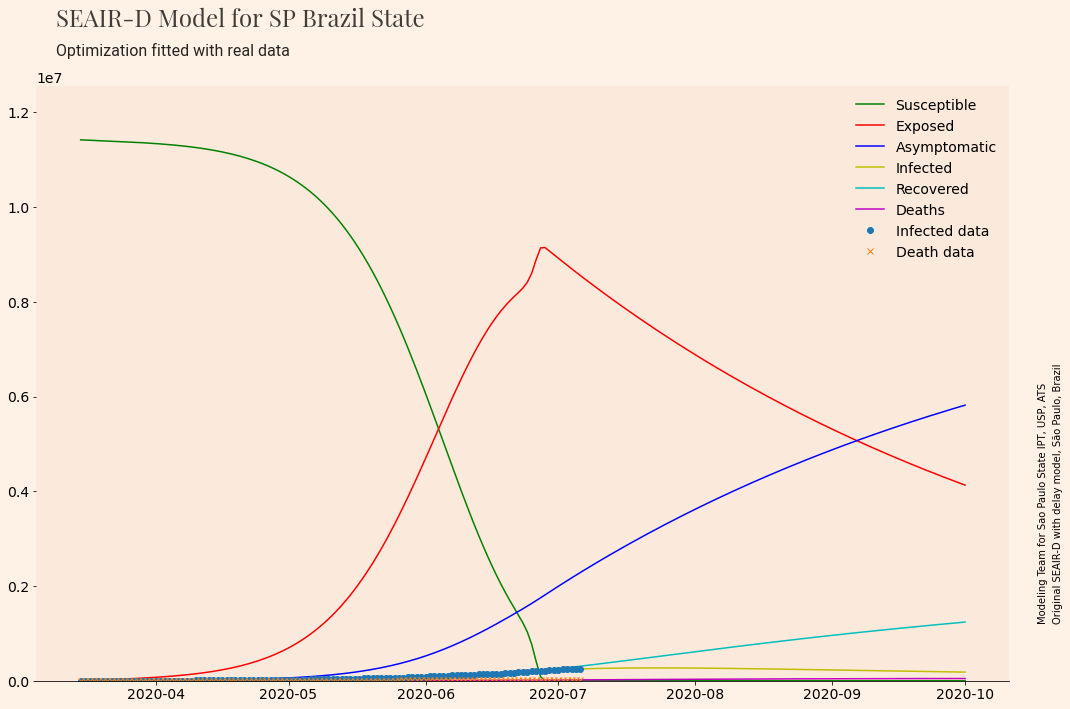

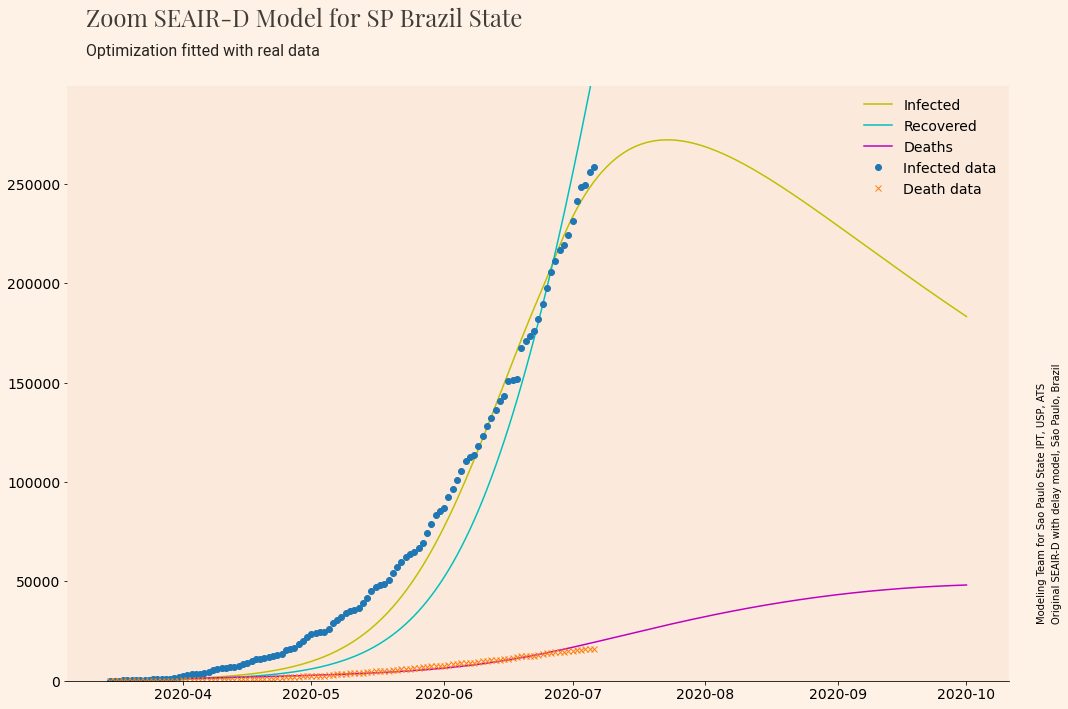

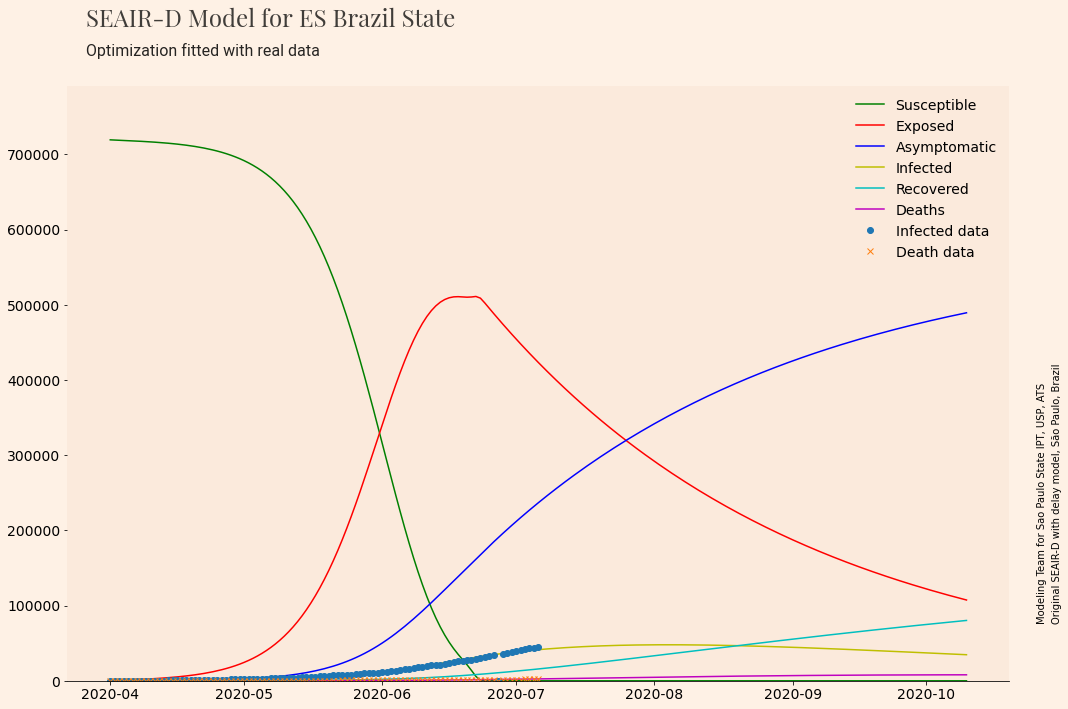

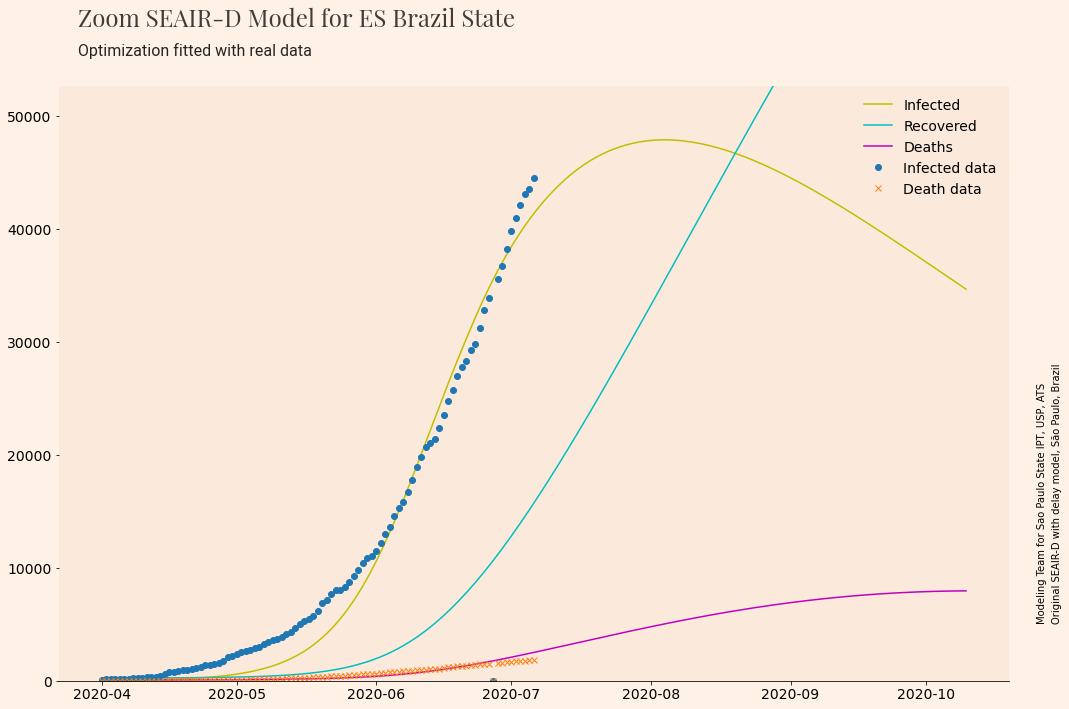

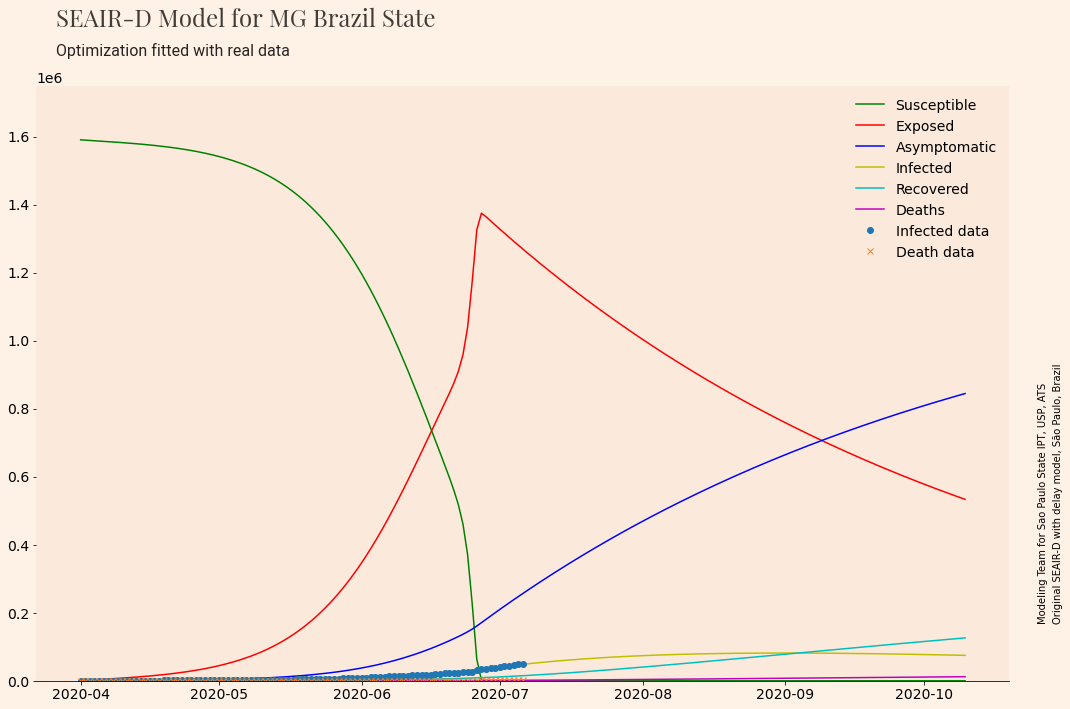

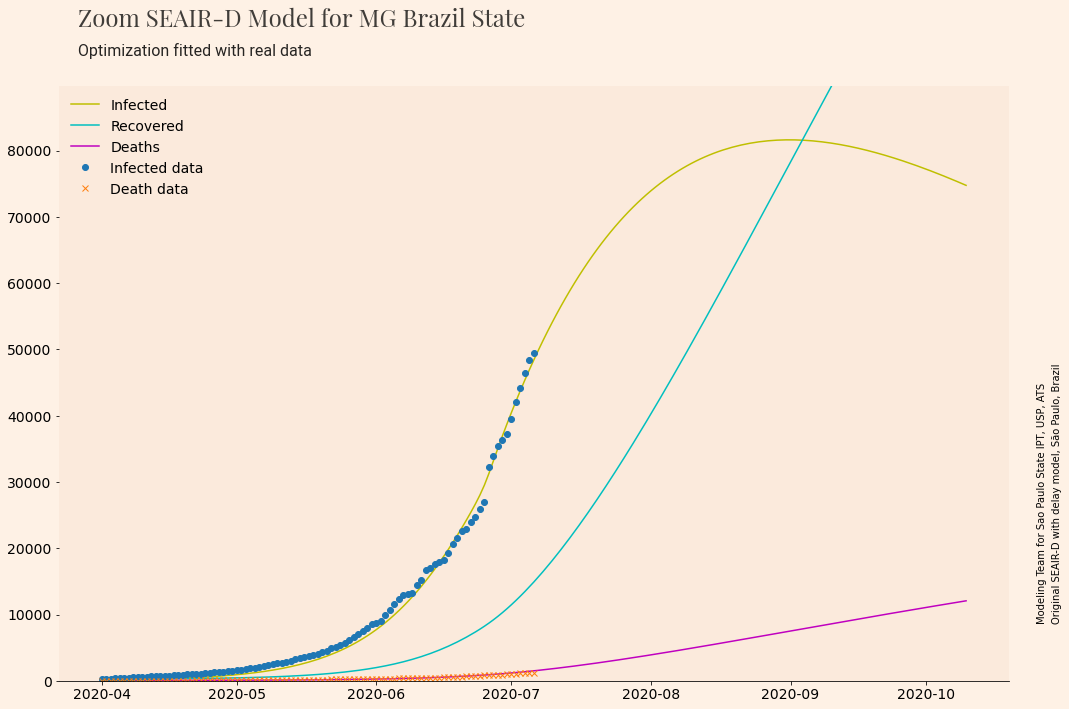

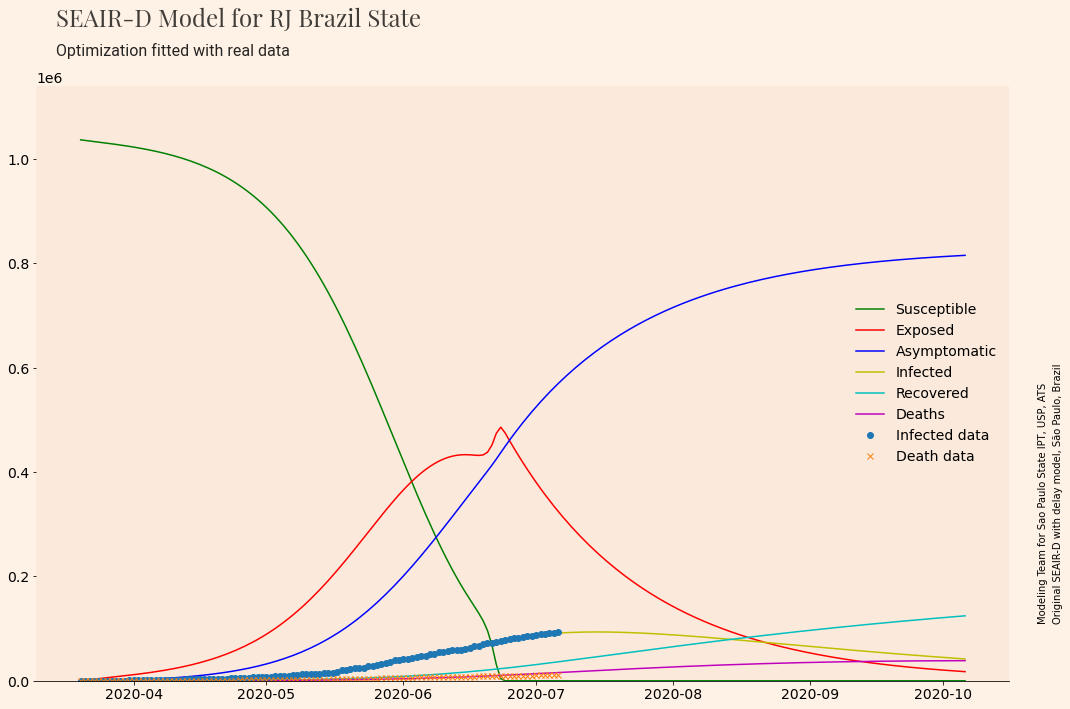

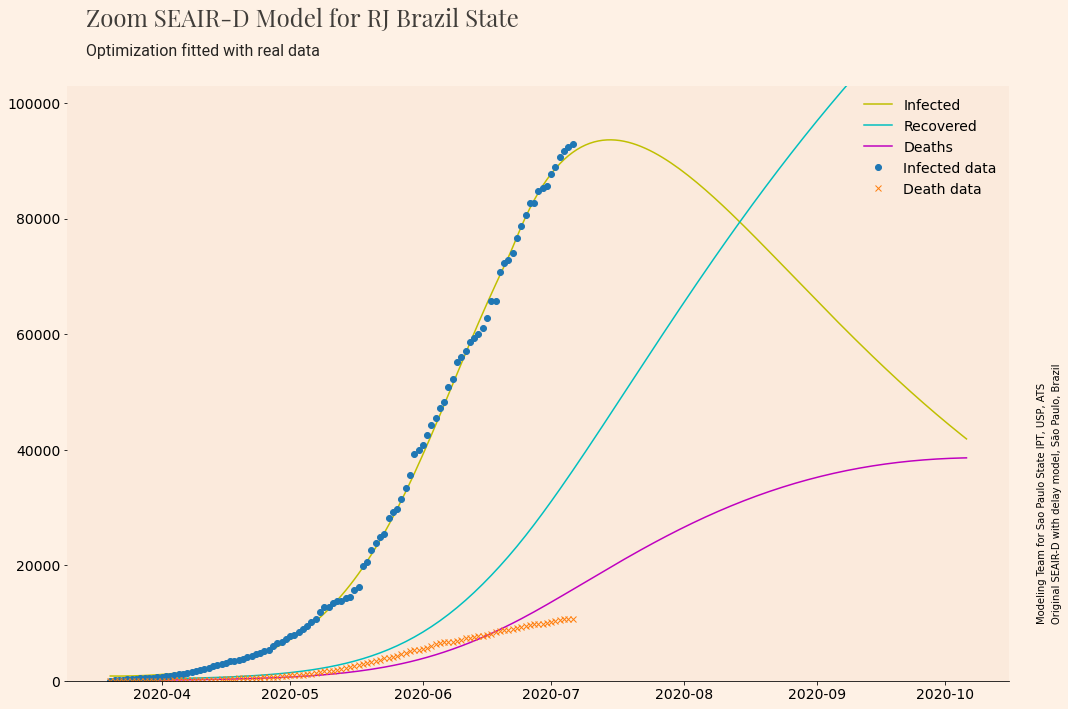

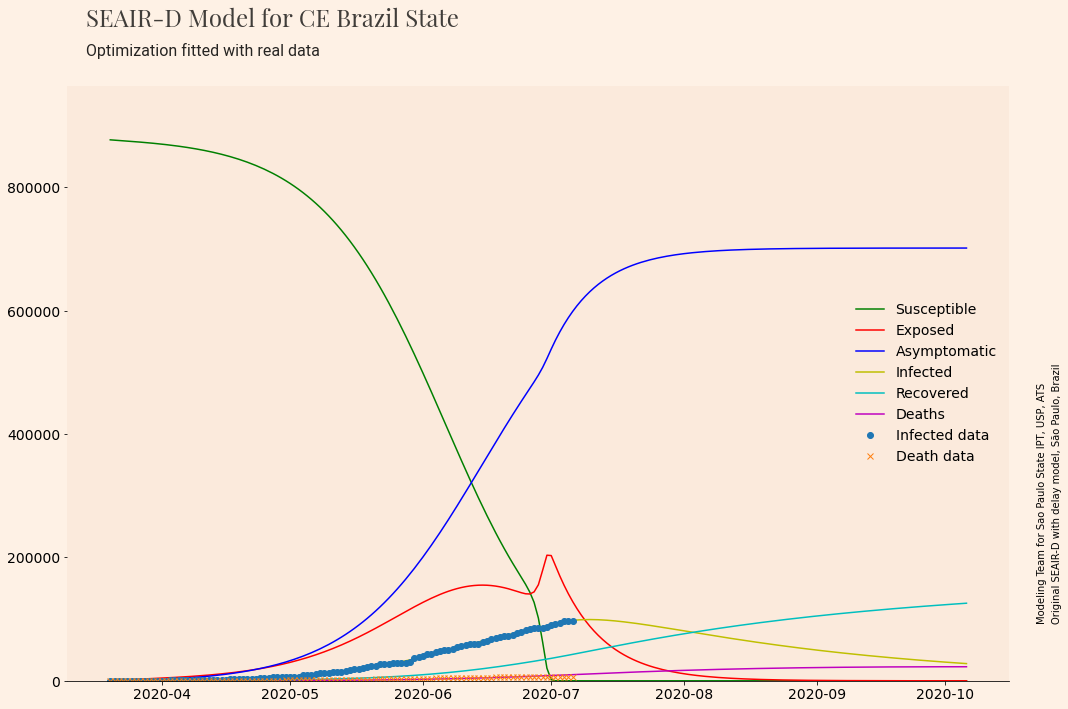

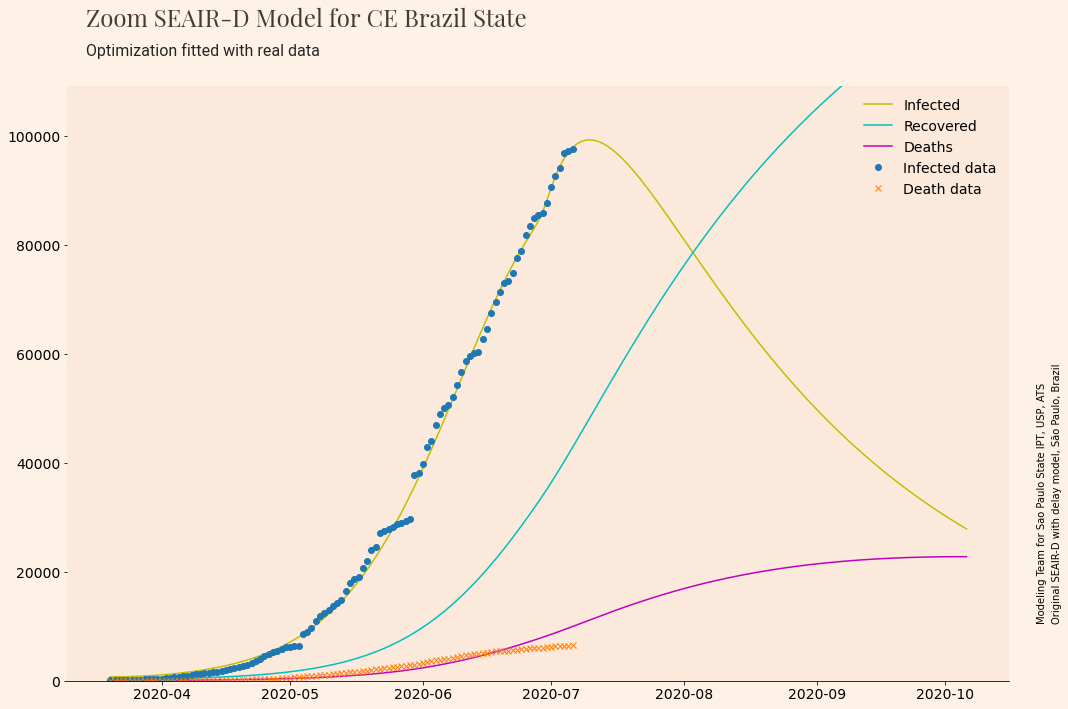

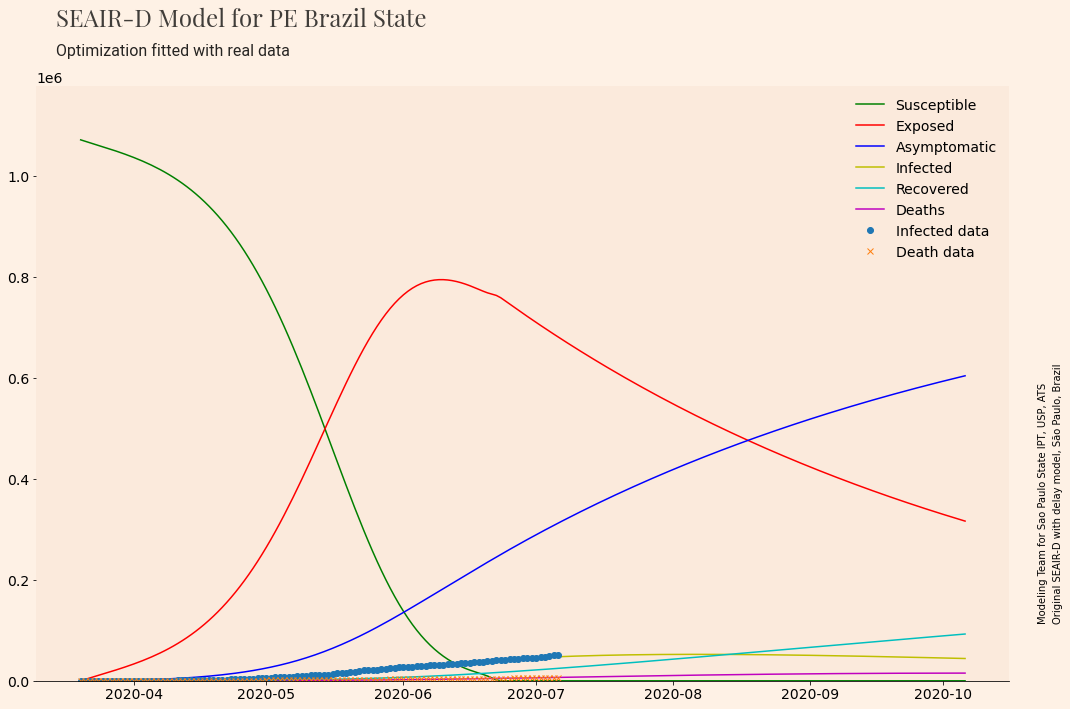

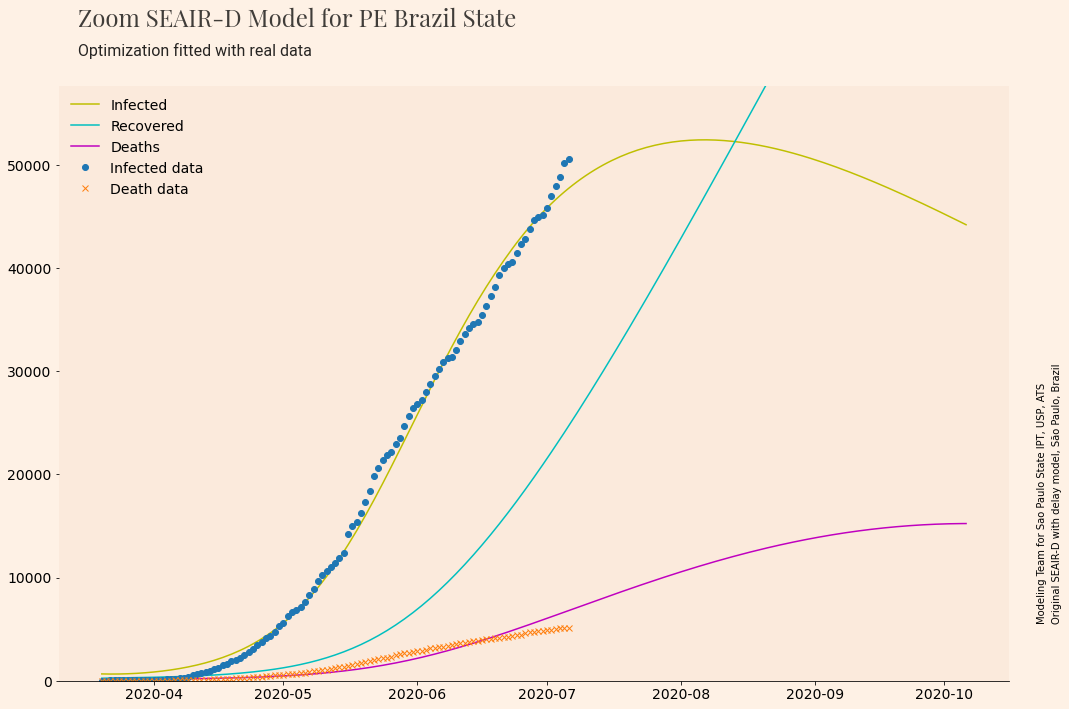

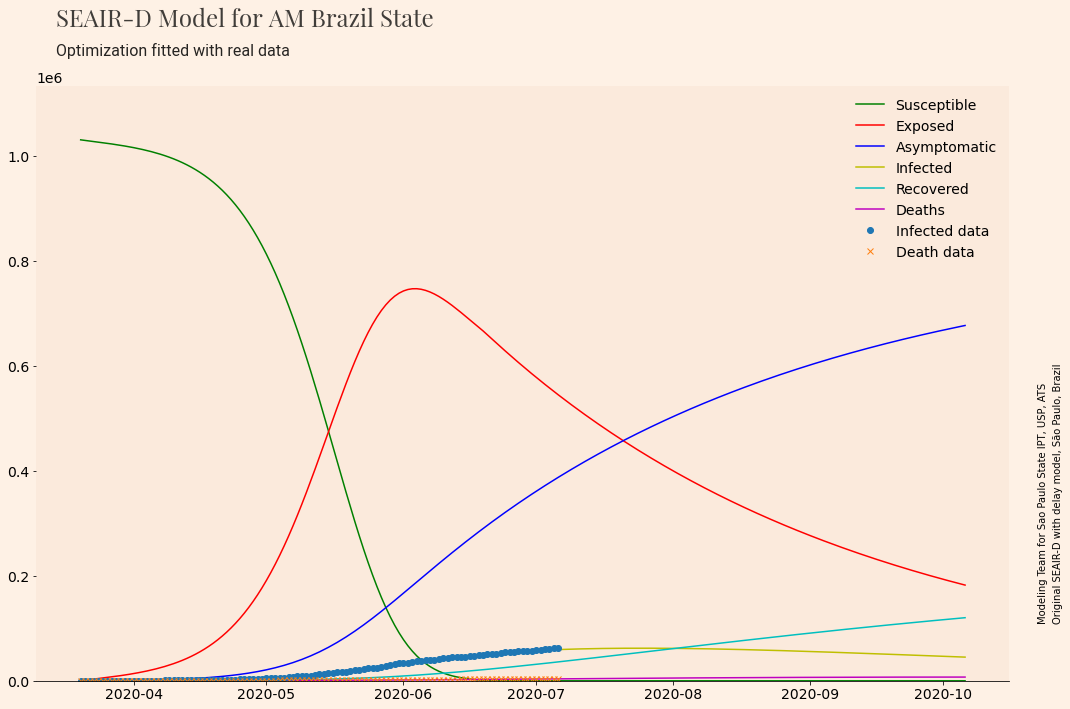

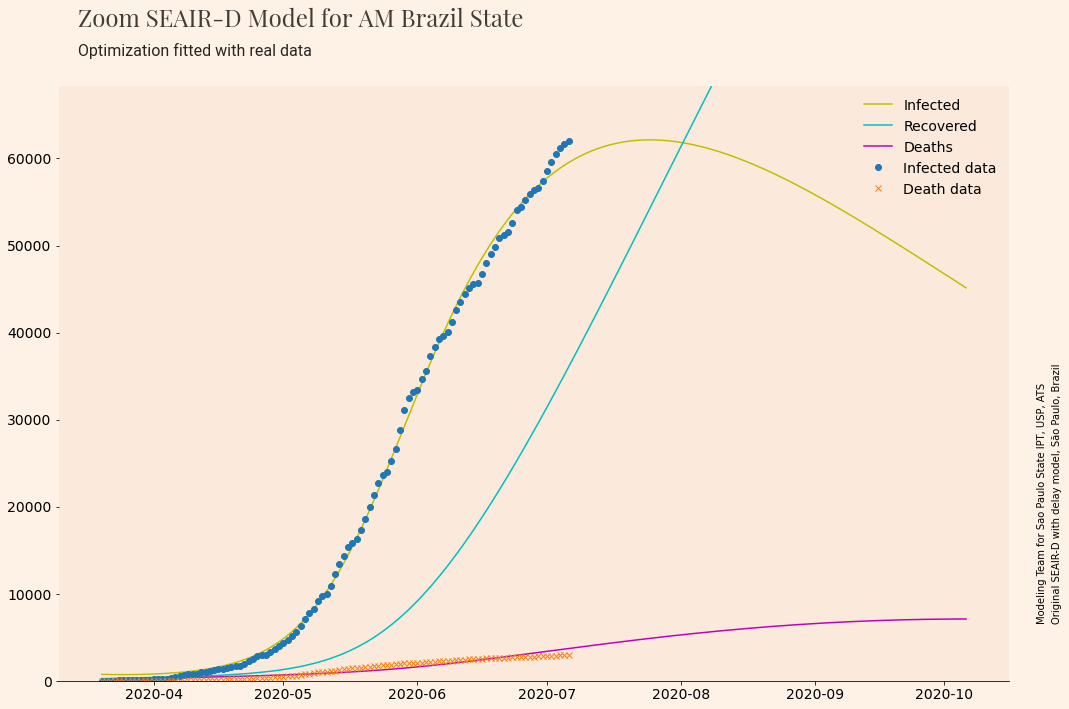

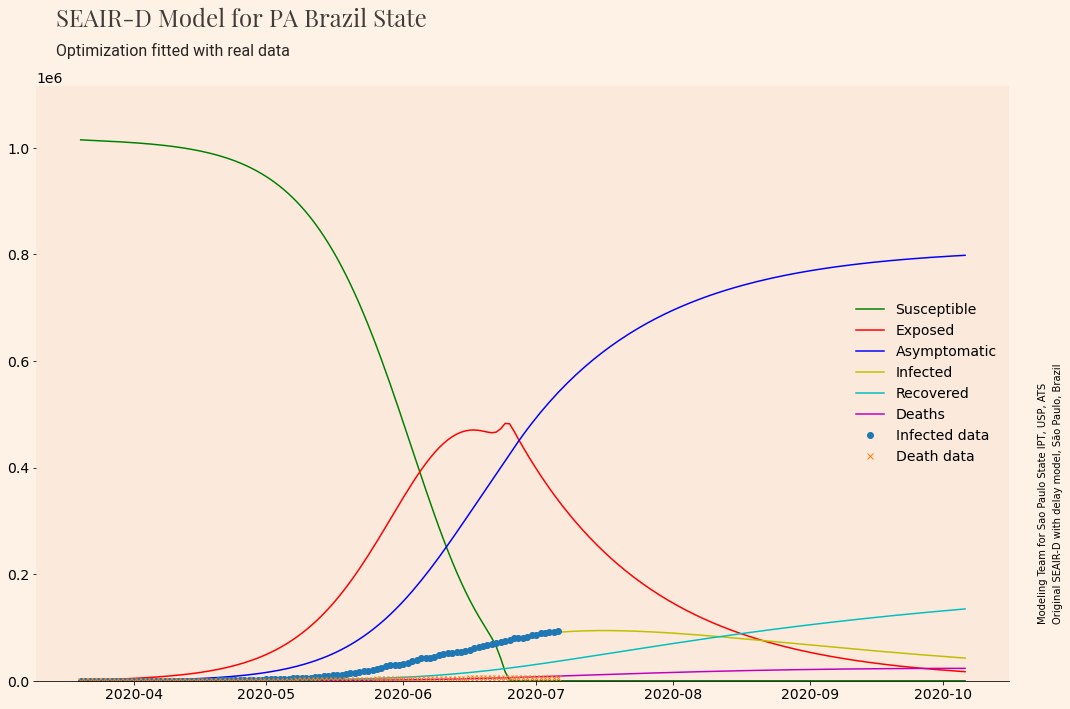

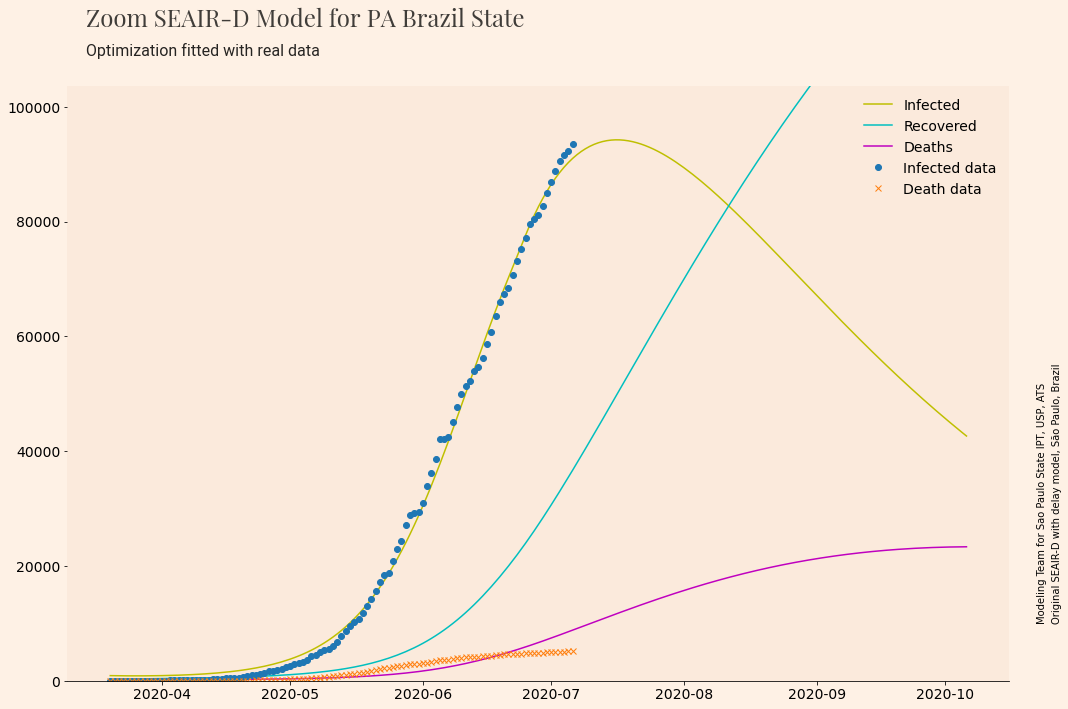

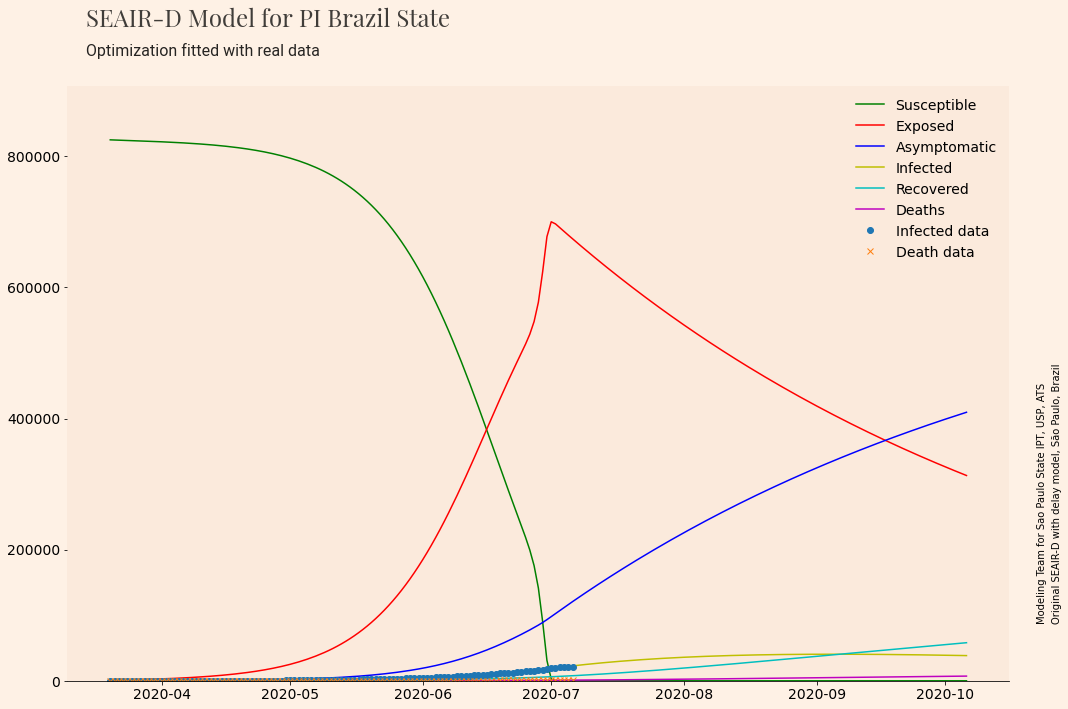

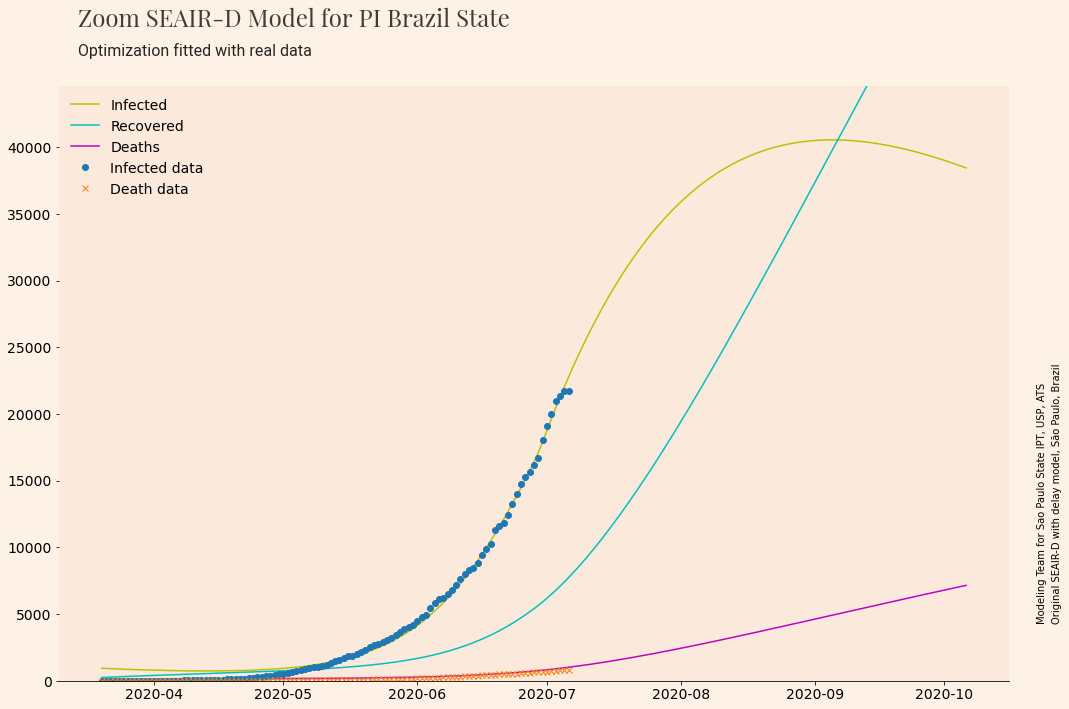

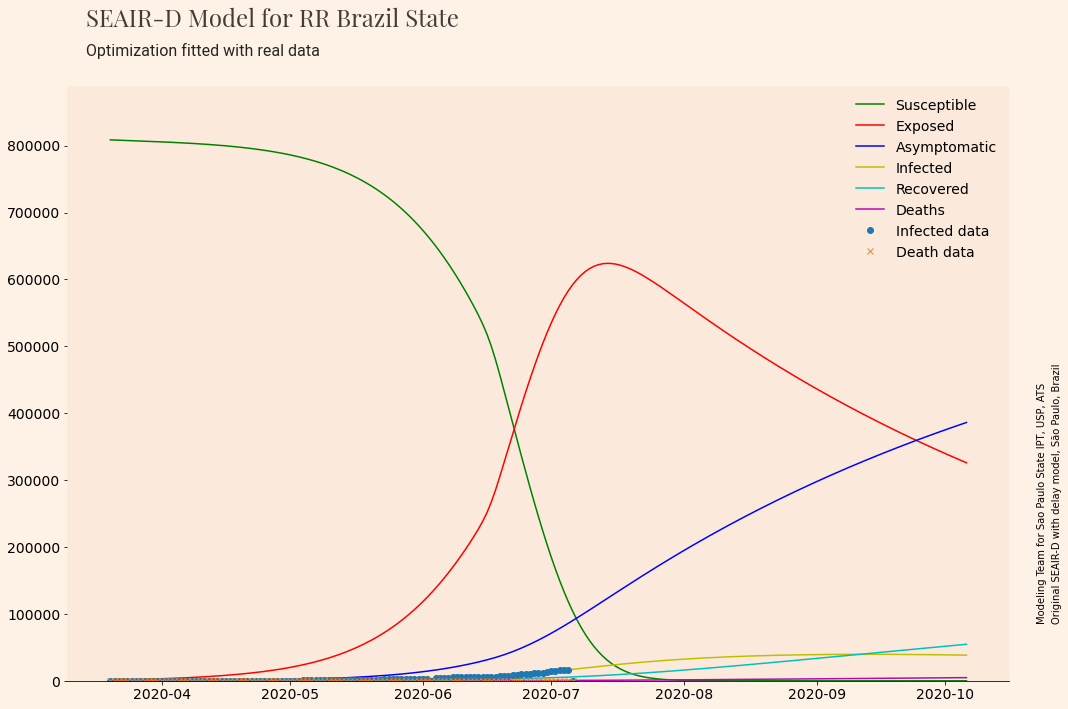

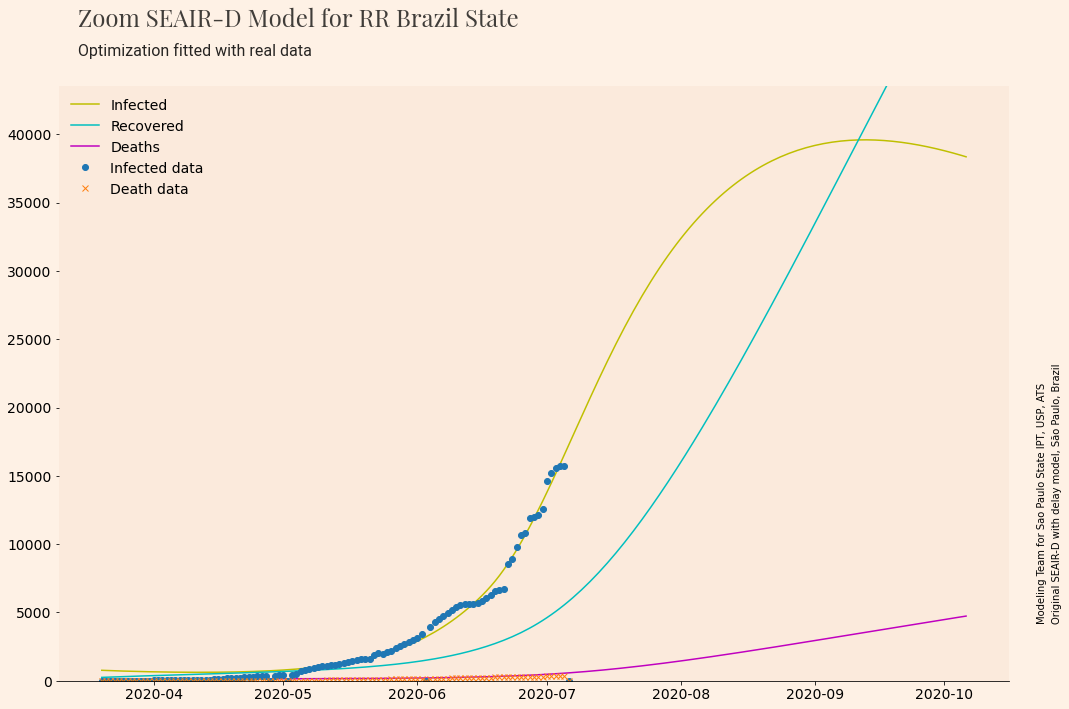

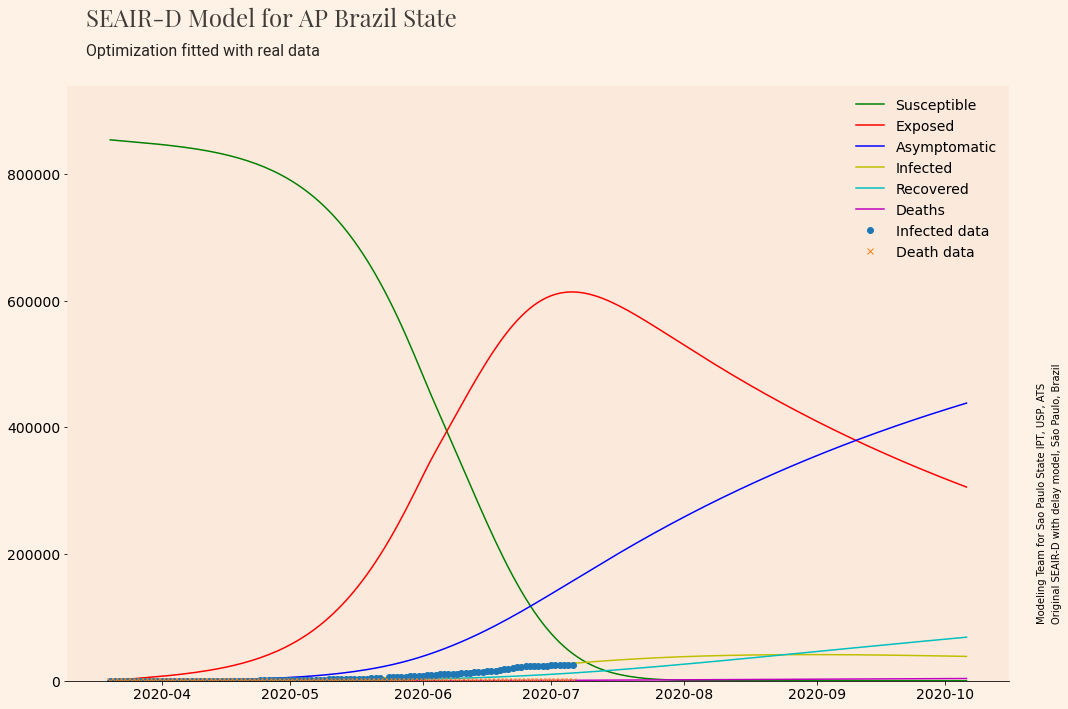

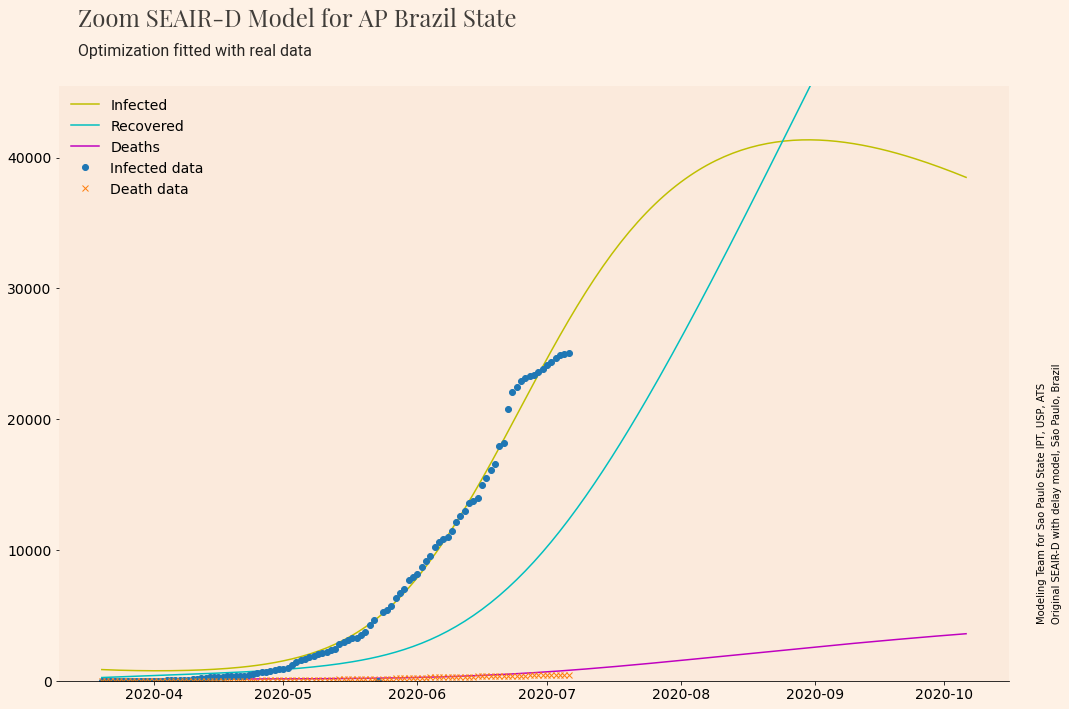

In [17]:
if allStates:
    for state in states:
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        ratio = query['RATIO'][0]
        startCase = query['START'][0]
        startdate = query['start-date'][0]
        predict_range = query['prediction-range'][0]
        
        #calcula data máxima dos gráficos
        #100 dias é usado como máximo dos cálculos da derivada das mortes
        lastDate=df.date.max()
        maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
        maxDateStr = maxDate.strftime("%Y-%m-%d")

        covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                        startCase, 5, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)
else: 
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    ratio = query['RATIO'][0]
    startdate = query['start-date'][0]
    predict_range = query['prediction-range'][0]
    startCase = query['START'][0]
    
    #calcula data máxima dos gráficos
    #100 dias é usado como máximo dos cálculos da derivada das mortes
    lastDate=df.date.max()
    maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
    maxDateStr = maxDate.strftime("%Y-%m-%d")    
    
    covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                       startCase, opt, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)